# How to simulate missing values in Python?
Thomas Schmitt, Sept. 2019

## Intro

Missing values occur in many domains and most datasets contain missing values (due to non-responses, lost records, machine failures, dataset fusions, etc.). These missing values have to be considered before or during analyses of these datasets.

Now, if you have a method that deals with missing values, for instance imputation or estimation with missing values, how can you assess the performance of your method on a given dataset? If the data already contains missing values, than this does not help you since you generally do not have a ground truth for these missing values. So you will have to simulate missing values, i.e. you remove values (ampute) – which you therefore know to be the ground truth – to generate missing values.

In the following we will briefly introduce amputation mechanism and propose ways of generate missing valuess.

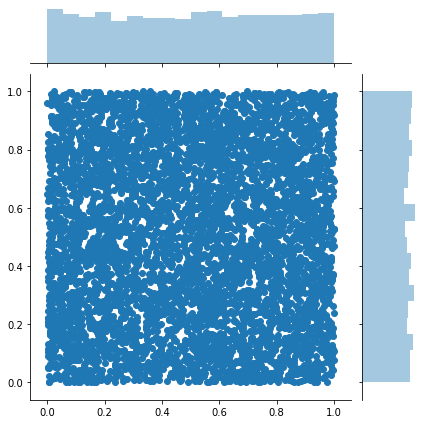

In [431]:
# first let's generate the complete data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

np.random.seed(0)  # fix the seed 

n_samples = 5900

mean = (0,0)
cov = [[1,.5],[.5,1]]
cov = [[1,0],[0,1]]
X_complete = np.random.multivariate_normal(mean, cov, size=n_samples)
X_complete = np.random.uniform(0, 1, size=(n_samples,2))

sns.jointplot(X_complete[:,0], X_complete[:,1], label = 'Complete data')

# Amputation

We want to simulate a matrix `X_obs` from `X_complete` with missing entries (remplacing some entries by `np.nan`).  
To do so we sample a missing pattern matrix `M` with same shape as `X_complete` indicating missing entries:  

$X_{obs} = X_{complete} \cdot \mathbb{1}_{\{M=0\}} + \mbox{np.nan} \cdot \mathbb{1}_{\{M=1\}}$


The mechanisms generating missing values can be various but usually they are classified into three main categories defined by [Rubin 1976](https://www.jstor.org/stable/2335739)

1. Missing Completly at Random (MCAR)
1. Missing at Random (MAR)
1. Missing Not at Random (MNAR)  

The first two are also qualified as ignorable missing values mechanisms, for instance in likelihood-based approaches to handle missing values, whereas the MNAR mechanism generates nonignorable missing values.  
For more informations we refer to the [R-miss-tastic website](https://rmisstastic.netlify.com/bibliography/).


## 1. MCAR Mechanism (Missing Completly at Random)

Values are Missing Completely At Random (MCAR) if the missingness pattern is independent of the values (observed or not). So the probability that an observation is missing does not depend on (X_obs and X_miss). Formally:  

$\mathbb{P} (M | X_{obs},X_{miss})= \mathbb{P}(M)\  \forall X_{obs},\  \forall X_{miss}$  
i.e. $M \perp \! \! \! \perp X_{complete} $  


Here $X_{miss}$ correponds to the missing values.



In Python, the easiest way is to sample a Bernouilli to mask some data point

In [432]:
def ampute_mcar(X_complete, missing_rate = .2):
    # Mask completly at random some values
    M = np.random.binomial(1, missing_rate, size = X_complete.shape)
    X_obs = X_complete.copy()
    np.putmask(X_obs, M, np.nan)
    return X_obs

In [433]:
X_obs_mcar = ampute_mcar(X_complete)

print('X_obs_mcar = ')
print(X_obs_mcar[:10])
print('  ...')

X_obs_mcar = 
[[0.49393799        nan]
 [       nan        nan]
 [       nan 0.51468104]
 [0.57275152 0.23703318]
 [0.28854573        nan]
 [0.33767913 0.71972114]
 [0.29835304 0.21042103]
 [       nan 0.10600488]
 [0.93471516 0.22275683]
 [0.46161675 0.71566021]]
  ...


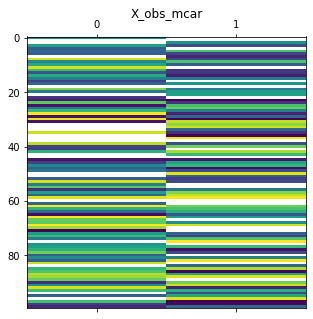

In [434]:
plt.figure(figsize=(5,5))
plt.matshow(X_obs_mcar[:100], aspect='auto', fignum=False)
plt.title('X_obs_mcar');

In [435]:
# ploting functions with seaborn
def _replace_nan_by_min(X_obs):
    # return X_obs where nan are replaced by min(X)
    row_with_missing = [any(np.isnan(x)) for x in X_obs]
    mask_missing = np.isnan(X_obs[row_with_missing])
    X_with_min = X_complete[row_with_missing].copy()
    nan_value = np.min(X_complete.ravel()) - np.var(X_complete.ravel())
    np.putmask(X_with_min, mask_missing, nan_value)
    return X_with_min

def scatter_plot_obs(X_obs):
    # scatter plot with historgams, nan replaced by the min
    
    X_miss_min = _replace_nan_by_min(X_obs)
    
    g = sns.JointGrid(X_obs[:,0], X_obs[:,1])
    sns.kdeplot(X_obs[:,0][~np.isnan(X_obs[:,0])], ax=g.ax_marg_x)
    sns.kdeplot(X_obs[:,1][~np.isnan(X_obs[:,1])], ax=g.ax_marg_y,
                vertical=True, label='observed')
    g.ax_joint.plot(X_obs[:,0], X_obs[:,1], "o", alpha = .7)
    sns.kdeplot(X_miss_min[X_miss_min[:,0] > min(X_miss_min[:,0])][:,0],
                ax=g.ax_marg_x)
    sns.kdeplot(X_miss_min[X_miss_min[:,1] > min(X_miss_min[:,1])][:,1],
                ax=g.ax_marg_y, vertical=True, label='missing')
    g.ax_joint.plot(X_miss_min[:,0], X_miss_min[:,1], "*", alpha = .7)
    
    plt.legend()
    plt.tight_layout()
    
def scatter_plot_with_missing_completed(X_obs, X_complete, 
                                        replace_nan_by_min=True):
    # scatter plot with historgams

    # use X_complete informations
    row_with_missing = [any(np.isnan(x)) for x in X_obs]
    X_missing = X_complete[row_with_missing]

    g = sns.JointGrid(X_obs[:,0], X_obs[:,1])
    sns.kdeplot(X_obs[:,0][~np.isnan(X_obs[:,0])], ax=g.ax_marg_x)
    sns.kdeplot(X_obs[:,1][~np.isnan(X_obs[:,1])], ax=g.ax_marg_y,
                vertical=True, label='observed')
    g.ax_joint.plot(X_obs[:,0], X_obs[:,1], "o", alpha = .7)
    sns.kdeplot(X_missing[:,0], ax=g.ax_marg_x)
    sns.kdeplot(X_missing[:,1], ax=g.ax_marg_y,
                    vertical=True, label='missing (comlpeted)')
    g.ax_joint.plot(X_missing[:,0], X_missing[:,1], "*", alpha = .7)
    
    plt.legend()
    plt.tight_layout()
    

def hist_plot(X_obs, X_complete):
    
    values_miss_0 = X_complete[:,0][np.isnan(X_obs[:,0])]
    values_miss_1 = X_complete[:,1][np.isnan(X_obs[:,1])]
    values_obs_0 = X_obs[:,0][~np.isnan(X_obs[:,0])]
    values_obs_1 = X_obs[:,1][~np.isnan(X_obs[:,1])]
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(values_obs_0, bins = 30, density=1,
             alpha = .4, label = 'observed values')
    plt.hist(values_miss_0, bins = 30, density=1,
             alpha = .4, label = 'missing values')
    plt.legend()
    plt.xlabel('X[:,0]')
    plt.title('distribution of the values on column 0')  
    plt.subplot(1,2,2)
    plt.hist(values_obs_1, bins = 30, density=1,
             alpha = .4, label = 'observed values')
    plt.hist(values_miss_1, bins = 30, density=1,
             alpha = .4, label = 'missing values')
    plt.legend()
    plt.xlabel('X[:,1]')
    plt.title('distribution of the values on column 1')  
    
    
def hist_plot_4(X_obs, X_complete):
    # histogram of obs vs. missing values
    
    values_miss_0 = X_complete[:,0][np.isnan(X_obs[:,0])]
    values_miss_1 = X_complete[:,1][np.isnan(X_obs[:,1])]
    values_obs_0 = X_obs[:,0][~np.isnan(X_obs[:,0])]
    values_obs_1 = X_obs[:,1][~np.isnan(X_obs[:,1])]
    
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.hist(values_obs_0, bins = 30, density=1,
             alpha = .4, label = 'observed values (col 0)')
    plt.hist(values_miss_0, bins = 30, density=1,
             alpha = .4, label = 'missing values (col 0)')
    plt.legend()
    plt.yticks([])
#     plt.ylabel('X_obs[:,0]')
    plt.title('X_obs[:,0] & X_miss[:,0]')
    plt.subplot(2,2,2)
    plt.hist(values_obs_0, bins = 30, density=1,
             alpha = .4, label = 'observed values (col 0)')
    plt.hist(values_miss_1, bins = 30, density=1,
             alpha = .4, label = 'missing values (col 1)')
    plt.legend()
    plt.yticks([])
    plt.title('X_obs[:,0] & X_miss[:,1]')
    
    plt.subplot(2,2,3)
    plt.hist(values_obs_1, bins = 30, density=1,
             alpha = .4, label = 'observed values (col 1)')
    plt.hist(values_miss_0, bins = 30, density=1,
             alpha = .4, label = 'missing values (col 0)')
    plt.legend()
#     plt.ylabel('X_obs[:,1]')
    plt.yticks([])
    plt.title('X_obs[:,0] & X_miss[:,1]')
    plt.subplot(2,2,4)
    plt.hist(values_obs_1, bins = 30, density=1,
             alpha = .4, label = 'observed values (col 1)')
    plt.hist(values_miss_1, bins = 30, density=1,
             alpha = .4, label = 'missing values (col 1)')
    plt.legend()
    plt.yticks([])
    plt.title('X_obs[:,0] & X_miss[:,1]')

Data with "MCAR" mechanism.


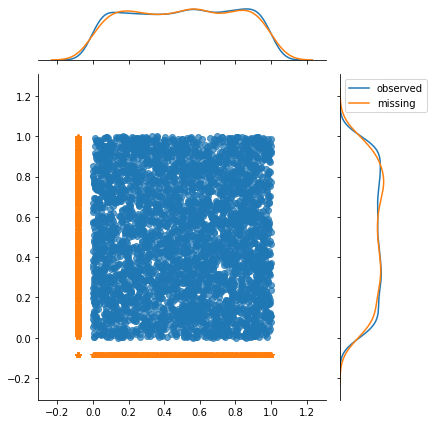

In [436]:
print('Data with "MCAR" mechanism.')
scatter_plot_obs(X_obs_mcar)

Samples completed with X_complete information.


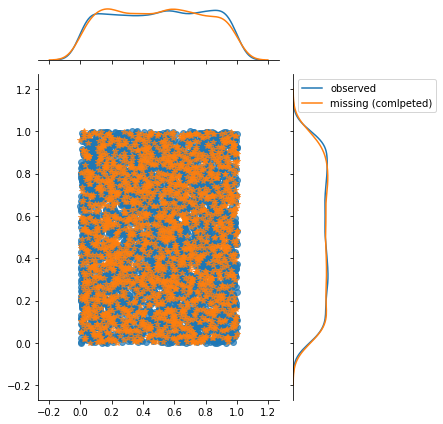

In [437]:
print('Samples completed with X_complete information.')
scatter_plot_with_missing_completed(X_obs_mcar, X_complete)

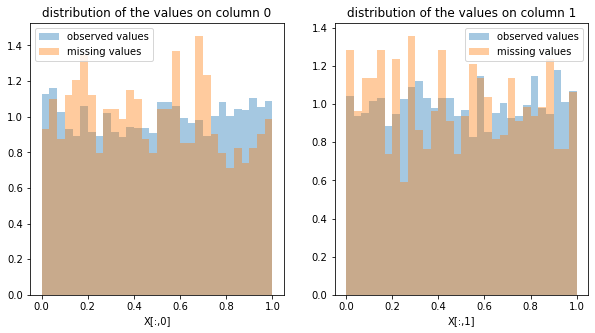

In [646]:
hist_plot(X_obs_mcar, X_complete)

Missing values is independant on the observed values

In [439]:
print('Percentage of newly generated mising values: {}'.\
      format(np.sum(np.isnan(X_obs_mcar))/X_obs_mcar.size))

Percentage of newly generated mising values: 0.19584745762711864


## 2. MAR (Missing At Random)

The values are said to be Missing At Random (MAR) if the probability that an entry is missing only depends on the observed values `X_obs`. Formally,

$\mathbb{P} (M | X\_{obs},X\_{miss})= \mathbb{P}(M|X\_{obs}), \forall X\_{miss}$  
i.e. $M \perp \! \! \! \perp X_{miss} \ |\ X\_{obs}$    

In [638]:
def ampute_mar(X_complete, W=None):
    """ ampute_mar
    
    
    For each sample, some observed feature (P=1) will influence 
    the missingness of some others features (P=0)
    
    e.g. during a questionnary, those who said being busy (X[:,0] high) 
    usualy miss to fill the last question (X[:,-1] = np.nan)
    """
    
    from sklearn.preprocessing import normalize
    # Sample a pattern matrix P
    # P[i,j] = 1 will correspond to an observed value
    # P[i,j] = 0 will correspond to a potential missing value
    P = np.random.binomial(1, .2, size=X_complete.shape)
    # .5 -> sample each kind of pattern equaly
#     P = np.array(P, dtype=bool)
    
    # potential missing entry do not take part of missingness computation
    X_not_missing = np.multiply(X_complete,P)
    # feature have equal importance for sampling missingness
    X_not_missing = normalize(X_not_missing, norm='l1', axis=0)

    if W is None:
        # generate weigths for each pattern
        W = np.random.randn(X_complete.shape[1], X_complete.shape[1])    
        
    M_proba = np.random.normal(X_not_missing.dot(W), scale = .00001)
    M_proba = X_not_missing.dot(W)
    
    # not missing should have M_proba = 0
#     print(M_proba)
    M_proba = np.multiply(M_proba, 1-P)  # M_proba[P] = 0
#     print(M_proba[:40])
#     M_proba = np.abs(np.array(M_proba))
#     M_proba += M_proba.mean(axis=0)
#     M_proba = normalize(M_proba, norm='l1')
#     print(M_proba)
    # compute thresold wrt missing_rate
    thresold = np.percentile(M_proba.ravel(), 100 * (1 - missing_rate))
    M = M_proba > thresold
    
    X_obs = X_complete.copy()
    np.putmask(X_obs, M, np.nan)
    return X_obs

In [639]:
W = np.array([[0,1],[0,0]]) 
# With this weight matrix W, 
# missingness on X[:,1] depends on X[:,0] value
X_obs_mar = ampute_mar(X_complete, W=W)

Data with "MAR" mechanism.


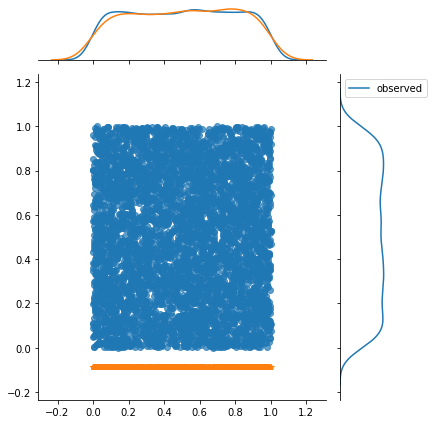

In [640]:
print('Data with "MAR" mechanism.')
scatter_plot_obs(X_obs_mar)

Samples completed with X_complete information.


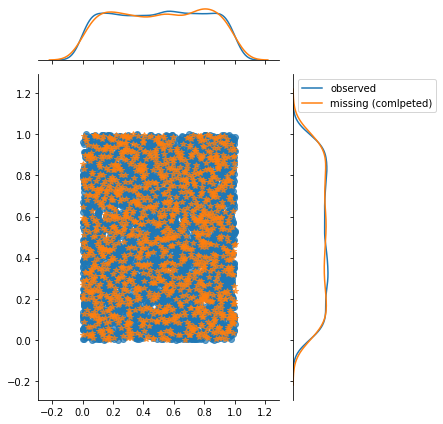

In [632]:
print('Samples completed with X_complete information.')
scatter_plot_with_missing_completed(X_obs_mar, X_complete)

/home/thomas/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


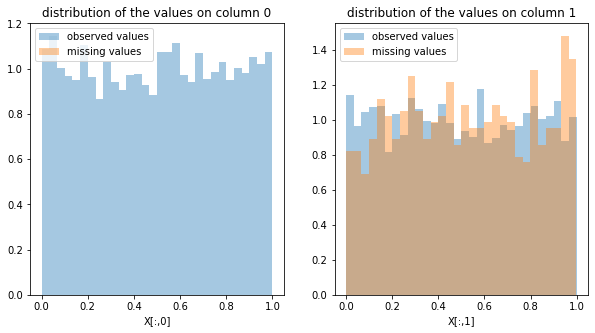

In [647]:
hist_plot(X_obs_mar, X_complete)

In [634]:
print('Percentage of newly generated mising values: {}'.\
      format(np.sum(np.isnan(X_obs_mar))/X_obs_mar.size))

Percentage of newly generated mising values: 0.11779661016949153


# MNAR (Missing Not At Random)

Otherwise, if neither MCAR nor MAR, values are Missing Not At Random (MNAR)
$\mathbb{P} (M | X\_obs, X\_mis)= \mathbb{P}(M|X\_obs), \forall X\_mis$

In [642]:
from scipy.special import expit as sigmoid  # logistic function

def ampute_mnar(X_complete, missing_rate = .2):
    """ ampute X_complete with censoring (Missing Not At Random)
    
    The missingness pattern depends of the values of X_complete
    This will tends to "censor" X[i,j] where X[i,j] is high 
    comparing to its column X[:,j]
    """
    
    # M depends on X_complete values
    M_proba = np.random.normal(X_complete)
    M_proba = normalize(M_proba, norm='l1')
#     M = np.multiply(M, 1/M.sum(axis=0)) # equal importance for each feature 
    
    # compute thresold wrt missing_rate
    thresold = np.percentile(M_proba.ravel(), 100 * (1- missing_rate))
    M = M_proba > thresold
    
    X_obs = X_complete.copy()
    np.putmask(X_obs, M, np.nan)
    
    return X_obs

In [643]:
X_obs_mnar = ampute_mnar(X_complete)

X_obs with "MNAR" mechanism


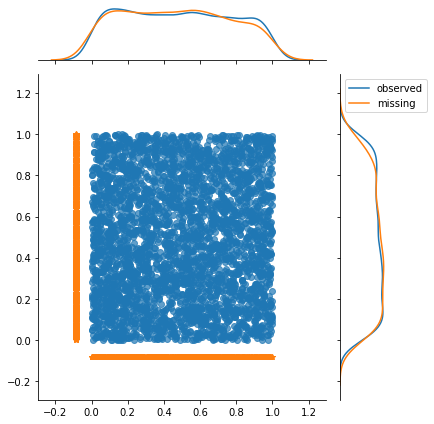

In [644]:
scatter_plot_obs(X_obs_mnar)
print('X_obs with "MNAR" mechanism')

Samples completed with X_complete information.


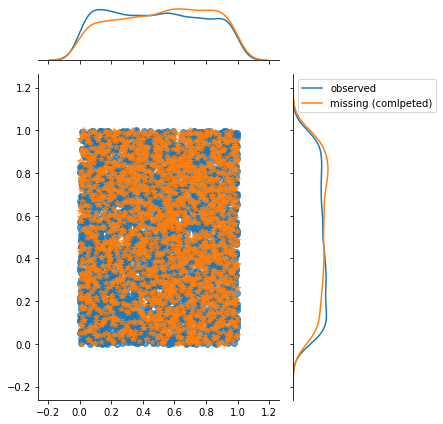

In [645]:
print('Samples completed with X_complete information.')
scatter_plot_with_missing_completed(X_obs_mnar, X_complete)

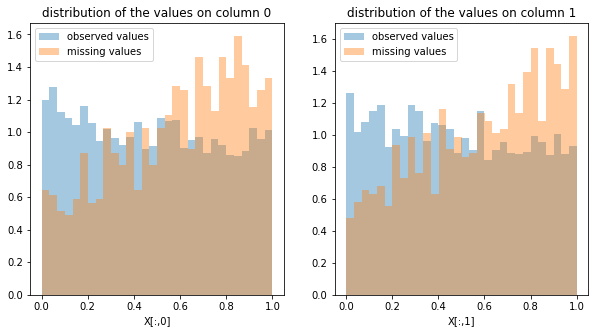

In [648]:
hist_plot(X_obs_mnar, X_complete)

The distribution of missing values is shifted to the right (comparing to the observed values' distribution).
The missingness pattern depends of the values of the missing entries.

In [270]:
print('Percentage of newly generated mising values: {}'.\
      format(np.sum(np.isnan(X_obs_mnar))/X_obs_mnar.size))

Percentage of newly generated mising values: 0.2


In [641]:
def stats(X_obs):
    col_perc = np.sum(np.isnan(X_obs), axis = 0)
    print(' percent of nan in each col = {}'.\
         format(col_perc))
    
    print('Percentage of newly generated mising values: {}'.\
      format(np.sum(np.isnan(X_obs))/X_obs.size))
    
stats(X_obs_mcar)
stats(X_obs_mar)
stats(X_obs_mnar)

 percent of nan in each col = [1095 1216]
Percentage of newly generated mising values: 0.19584745762711864
 percent of nan in each col = [  0 914]
Percentage of newly generated mising values: 0.07745762711864407
 percent of nan in each col = [1189 1171]
Percentage of newly generated mising values: 0.2


## Additional remarks

See also the R [ampute](https://rianneschouten.github.io/mice_ampute/vignette/ampute.html) algorithm from the R package [Mice](https://www.rdocumentation.org/packages/mice/versions/3.6.0/topics/mice)

We can also include the label `y` is the data. So the missingness could also depend of the target (predicitve missingness).

In [ ]:

def hist_plot(X_obs, X_complete):
    # histogram of observed values and missing values
    
    values_missing = X_complete[np.isnan(X_obs)]
    plt.hist(X_obs[~np.isnan(X_obs)], bins = 30, density=1,
             alpha = .4, label = 'observed values')
    plt.hist(values_missing, bins = 30, density=1,
             alpha = .4, label = 'missing values')
    plt.legend()
    plt.title('distribution of the values')  
    
    
def plot_data_v0(X_complete, X_obs):
    
    scatter_plot_with_missing(X_complete, X_obs)
    
    plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
    plt.subplot(1,3,1, colspan=2)
#     row_with_missing = [any(np.isnan(x)) for x in X_obs]
#     plt.scatter(X_obs[:, 0], X_obs[:, 1], label='non-missing', alpha = 1)
#     plt.scatter(X_complete[row_with_missing, 0], X_complete[row_with_missing, 1],
#                     marker='*', s = 40, label='missing coordinate')
#     plt.legend()
#     plt.xlabel("X0")
#     plt.ylabel("X1")
#     plt.title('Scatter plot');
    values_missing = X_complete[np.isnan(X_obs)]
    plt.hist(X_complete.ravel(), bins = 50, density=1,
             alpha = .4, label = 'complete data')
    plt.hist(values_missing, bins = 20, density=1,
             alpha = .4, label = 'missing values')
    plt.legend()
    plt.subplot(1,3,2, colspan=1)
    plt.matshow(X_obs[:60], fignum=False, aspect='auto');
    plt.title('X_obs');
    plt.xticks([])
    plt.yticks([])